# Capstone 3 - Modeling

## Predict Product Alignment

### Create a classifier that will predict which product the complaint is aligned to 
- This will allow the end user of this model to be able to identify areas with a higher number of complaints with respect to others

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import time
from tqdm import tqdm
from collections import Counter
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, roc_auc_score, accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2, SelectFromModel, VarianceThreshold, SelectKBest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import resample, class_weight
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
%matplotlib inline
plt.style.use('ggplot')

In [87]:
# load autoreload extension
#%load_ext autoreload

# always reload modules marked with %aimport
%autoreload 1

PROJ_ROOT = "/Users/joeboardman/Documents/Springboard/GitHub/CapstoneThree/"
import sys
src_dir = PROJ_ROOT
sys.path.append(src_dir)

%aimport myfunctions
from myfunctions import add_or_remove_stop_words
from myfunctions import chi2_test
from myfunctions import perf_summary
from myfunctions import nfeature_f1_checker
from myfunctions import SelectFromModel_accuracies
from myfunctions import chi2_feat_sel
from myfunctions import plot_feat_sel
from myfunctions import plot_roc_PR_curves
from myfunctions import classif_rep
from myfunctions import SFM_feat_sel

In [4]:
load_path = "/Users/joeboardman/Documents/Springboard/GitHub/CapstoneThree/data/processed/"
fig_save_path = "/Users/joeboardman/Documents/Springboard/GitHub/CapstoneThree/figures/"
os.chdir(load_path)
df_banks_filename = 'DW_complaints.csv'
df_banks = pd.read_csv(df_banks_filename, index_col=0)
#tfidf_train = pd.read_csv(tfidf_train_filename)
#tfidf_test = pd.read_csv(tfidf_test_filename)

In [5]:
# drop rows without a written complaint
df_banks = df_banks.sample(n=20000, random_state=34)
df_banks = df_banks.dropna(subset=['preprocessed_complaint']).reset_index(drop=True)
df_banks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Product                 20000 non-null  object 
 1   Issue                   20000 non-null  object 
 2   complaint_text          20000 non-null  object 
 3   Company                 20000 non-null  object 
 4   company_response        20000 non-null  object 
 5   disputed                20000 non-null  int64  
 6   complaint_ID            20000 non-null  int64  
 7   sentences               20000 non-null  int64  
 8   words                   20000 non-null  int64  
 9   special_chars           20000 non-null  int64  
 10  preprocessed_complaint  20000 non-null  object 
 11  polarity                20000 non-null  float64
 12  subjectivity            20000 non-null  float64
 13  sentiment_vader         20000 non-null  float64
dtypes: float64(3), int64(5), object(6)
mem

In [6]:
# train test split - categorize

X = df_banks.drop(['Product'], axis=1)
y = df_banks['Product']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34)


In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(16000, 13)
(16000,)
(4000, 13)
(4000,)


In [52]:
stop_words = set(stopwords.words('english')) 

In [12]:
# tfidf vectorizer

t0 = time()

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000, stop_words=stop_words)
tfidf_train = tfidf_vectorizer.fit_transform(X_train.preprocessed_complaint)
tfidf_test = tfidf_vectorizer.transform(X_test.preprocessed_complaint)

# convert tfidf to dataframe 
tfidf_train = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())
tfidf_test = pd.DataFrame(tfidf_test.A, columns=tfidf_vectorizer.get_feature_names())

print('Runtime:', round((time() - t0) / 60,1), 'minutes')

Runtime: 0.3 minutes


In [13]:
# summarize old distribution
counter = Counter(y_train)
for k, v in counter.items():
    per = v / len(y_train) * 100
    print('Class = %s, n = %d (%.3f%%)' % (k, v, per))

Class = Consumer Loan, n = 3948 (24.675%)
Class = Bank account or service, n = 4143 (25.894%)
Class = Other financial service, n = 492 (3.075%)
Class = Credit reporting, n = 1409 (8.806%)
Class = Credit card or prepaid card, n = 5047 (31.544%)
Class = Debt collection, n = 961 (6.006%)


In [14]:
# over sample to get balanced classes - 15-20 min run time
t0 = time()

smote = SMOTE(random_state=34)
tfidf_sm, y_sm = smote.fit_resample(tfidf_train, y_train)
print(tfidf_sm.shape, y_sm.shape)
print('Runtime:', round((time() - t0) / 60,1), 'minutes')

(30282, 10000) (30282,)
Runtime: 12.1 minutes


In [15]:
# summarize new distribution
counter = Counter(y_sm)
for k, v in counter.items():
    per = v / len(y_sm) * 100
    print('Class=%s, n=%d (%.3f%%)' % (k, v, per))

Class=Consumer Loan, n=5047 (16.667%)
Class=Bank account or service, n=5047 (16.667%)
Class=Other financial service, n=5047 (16.667%)
Class=Credit reporting, n=5047 (16.667%)
Class=Credit card or prepaid card, n=5047 (16.667%)
Class=Debt collection, n=5047 (16.667%)


# Model 1 - Random Forest Classifier

## Comments:
# ----------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------

# Random Forest Feature Selection
- Tried two feature selection methods
    - One used feature importances within RF model
    - Other used chi2 test on all features to choose K best features to include

In [81]:
vec = TfidfVectorizer()
rf = RandomForestClassifier(random_state=34)
n_features = np.arange(1000,10000,1000)

In [89]:
# results of model using different number of features with selectfrommodel feature importances
result_df_rf = SelectFromModel_accuracies(classifier=rf, X_train=tfidf_sm, y_train=y_sm, 
                                         X_test=tfidf_test, y_test=y_test, n_features=n_features)

RandomForestClassifier(random_state=34)


Validation result for 1000 features
Weighted f1 score: 78.13%
run time: 140.13s
--------------------------------------------------------------------------------
Validation result for 2000 features
Weighted f1 score: 78.37%
run time: 144.77s
--------------------------------------------------------------------------------
Validation result for 3000 features
Weighted f1 score: 77.90%
run time: 153.39s
--------------------------------------------------------------------------------
Validation result for 4000 features
Weighted f1 score: 78.03%
run time: 164.08s
--------------------------------------------------------------------------------
Validation result for 5000 features
Weighted f1 score: 78.40%
run time: 173.83s
--------------------------------------------------------------------------------
Validation result for 6000 features
Weighted f1 score: 78.13%
run time: 178.74s
-------------------------------------------------------------------------

In [92]:
# run chi2 test to select top features for 1,000-10,000 features
rf_chi2 = chi2_test(classifier=rf, X_train=tfidf_sm, y_train=y_sm, X_test=tfidf_test, y_test=y_test, n_features=n_features)

chi2 feature selection evaluation calculated for 1000 features
chi2 feature selection evaluation calculated for 2000 features
chi2 feature selection evaluation calculated for 3000 features
chi2 feature selection evaluation calculated for 4000 features
chi2 feature selection evaluation calculated for 5000 features
chi2 feature selection evaluation calculated for 6000 features
chi2 feature selection evaluation calculated for 7000 features
chi2 feature selection evaluation calculated for 8000 features
chi2 feature selection evaluation calculated for 9000 features


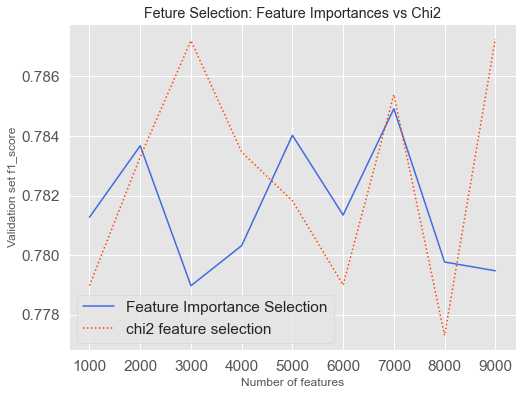

In [132]:
# plot model outputs with different number of features
fig = plot_feat_sel(result_df_rf, rf_chi2)
fig.savefig(fig_save_path + 'chi2_SFM_compare_rf.png')

In [94]:
# create new X_train and X_test using chi2 formula to select features
X_train_chi2_rf, X_test_chi2_rf = chi2_feat_sel(3000, X_train=tfidf_sm, y_train=y_sm, X_test=tfidf_test, y_test=y_test)

# Random Forest Modeling
- Using chi2 Feature selection from prior step, used optimal features to then tune hyperparameters and run Random Forest Model

In [95]:
# gridsearch on random forest - 5 hr run time
t0 = time()

max_depth = [5, 15, 30]
max_depth.append(None)
criterion = ('gini', 'entropy')
max_features = ['auto']
min_samples_split = [2, 5]
min_samples_leaf = [1, 2, 5]
bootstrap=[True]

param_grid = {
    'max_depth':max_depth,
    'criterion':criterion,
    'max_features':max_features,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf,
    'bootstrap':bootstrap
}

rf_gscv = RandomForestClassifier(random_state=34)

gs_rf = GridSearchCV(estimator=rf_gscv, param_grid=param_grid, scoring='f1_weighted',cv=3, verbose=2, n_jobs = -1)
gs_rf.fit(X_train_chi2_rf, y_sm)
print(gs_rf.best_params_)
print('Runtime:', round((time() - t0) / 60,1), 'minutes')

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/joeboardman/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 37.2min finished


{'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}
Runtime: 38.0 minutes


In [96]:
# Random forest classifier to predict complaint category

t0 = time()
#y_train = y_train.ravel()
rf_classifier = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=None, 
                                       max_features='auto', min_samples_leaf=1, min_samples_split=2, 
                                       random_state=34) #, class_weight='balanced'
rf_classifier.fit(X_train_chi2_rf, y_sm)
y_pred_rf = rf_classifier.predict(X_test_chi2_rf)
y_pred_proba_rf = rf_classifier.predict_proba(X_test_chi2_rf)
runtime_rf = round((time() - t0) / 60,1)
print('Runtime:', runtime_rf, 'minutes')

metrics_rf = ['Random Forest Classification', round(f1_score(y_test, y_pred_rf, average='weighted'),3), runtime_rf]

Runtime: 1.0 minutes


Model Results:


Weighted f1-score: 0.787


Classicication Report:
                             precision    recall  f1-score   support

    Bank account or service       0.80      0.87      0.83      1005
              Consumer Loan       0.88      0.85      0.87       961
Credit card or prepaid card       0.81      0.83      0.82      1293
           Credit reporting       0.58      0.62      0.60       369
            Debt collection       0.61      0.48      0.54       247
    Other financial service       0.68      0.43      0.53       125

                   accuracy                           0.79      4000
                  macro avg       0.73      0.68      0.70      4000
               weighted avg       0.79      0.79      0.79      4000



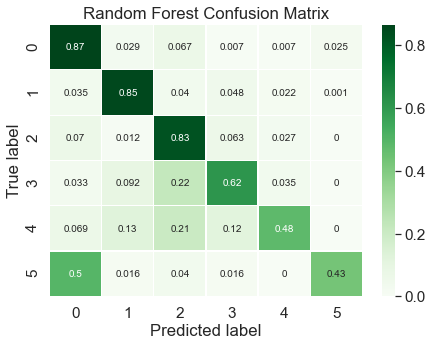

In [99]:
fig = classif_rep(y_test, y_pred_rf, 'Random Forest')
fig.figure.savefig(fig_save_path + 'rf_conf_matrix.png')

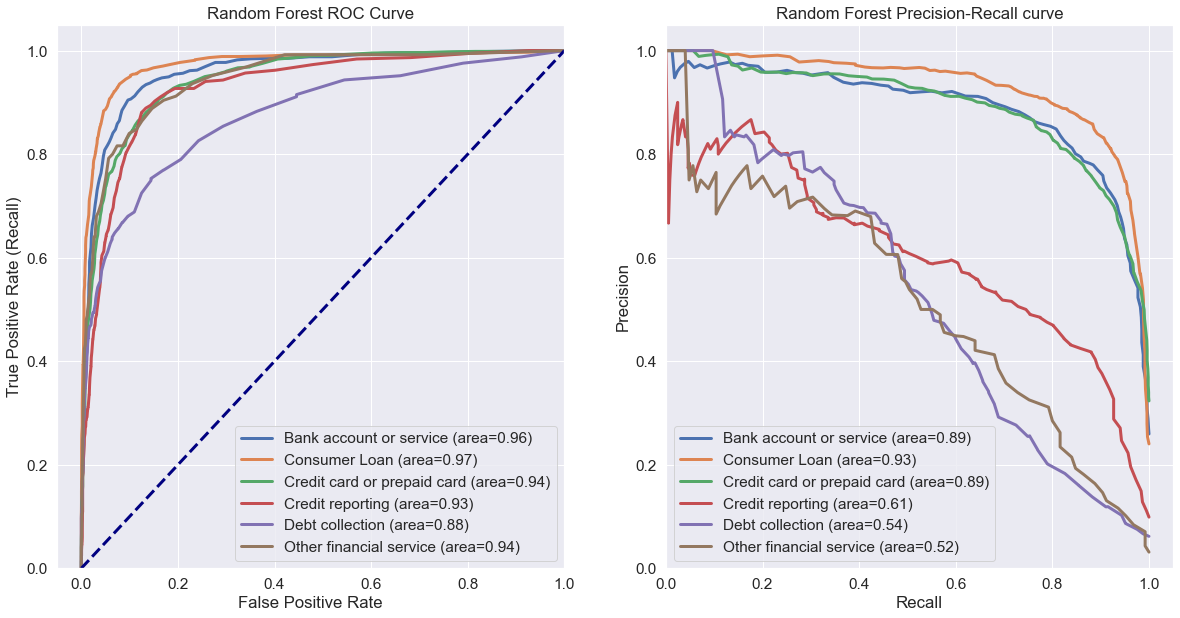

In [100]:
fig = plot_roc_PR_curves(y_test, y_pred_proba_rf, 'Random Forest')
fig.savefig(fig_save_path + 'rf_ROC_PR_curves.png')

# Model 2 - Naive Bayes Classifier
# ----------------------------------------------------------------------------
# ----------------------------------------------------------------------------

# Naive Bayes Feature Selection

In [101]:
# classifier to use for selectfrommodel and chi2 feature selection test
nb = MultinomialNB()

In [129]:
result_df_nb = SelectFromModel_accuracies(classifier=nb, X_train=tfidf_sm, y_train=y_sm, 
                                         X_test=tfidf_test, y_test=y_test, n_features=n_features)

MultinomialNB()


Validation result for 1000 features
Weighted f1 score: 48.74%
run time: 9.03s
--------------------------------------------------------------------------------
Validation result for 2000 features
Weighted f1 score: 55.99%
run time: 4.71s
--------------------------------------------------------------------------------
Validation result for 3000 features
Weighted f1 score: 60.06%
run time: 5.92s
--------------------------------------------------------------------------------
Validation result for 4000 features
Weighted f1 score: 63.74%
run time: 6.72s
--------------------------------------------------------------------------------
Validation result for 5000 features
Weighted f1 score: 67.06%
run time: 4.48s
--------------------------------------------------------------------------------
Validation result for 6000 features
Weighted f1 score: 70.59%
run time: 6.21s
--------------------------------------------------------------------------------
Validation result for 7000 f

In [130]:
# run chi2 test to select top features for 1,000-10,000 features
nb_chi2 = chi2_test(classifier=nb, X_train=tfidf_sm, y_train=y_sm, X_test=tfidf_test, y_test=y_test, n_features=n_features)

chi2 feature selection evaluation calculated for 1000 features
chi2 feature selection evaluation calculated for 2000 features
chi2 feature selection evaluation calculated for 3000 features
chi2 feature selection evaluation calculated for 4000 features
chi2 feature selection evaluation calculated for 5000 features
chi2 feature selection evaluation calculated for 6000 features
chi2 feature selection evaluation calculated for 7000 features
chi2 feature selection evaluation calculated for 8000 features
chi2 feature selection evaluation calculated for 9000 features


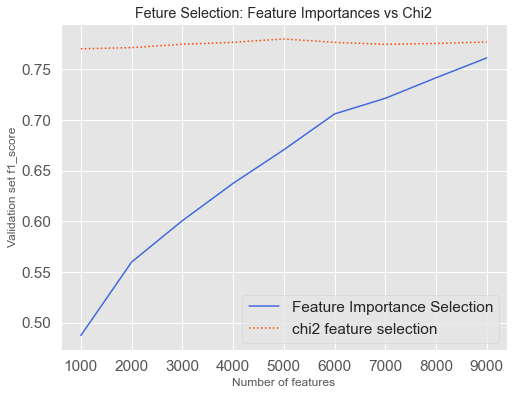

In [131]:
# plot model outputs with different number of features
fig = plot_feat_sel(result_df_nb, nb_chi2)
fig.savefig(fig_save_path + 'chi2_SFM_compare_nb.png')

In [105]:
# create new X_train and X_test using chi2 formula to select features
X_train_chi2_nb, X_test_chi2_nb = chi2_feat_sel(5000, X_train=tfidf_sm, y_train=y_sm, X_test=tfidf_test, y_test=y_test)

# Naive Bayes Modeling

In [106]:
# test of alphas on Naive Bayes

alphas = [0.001, 0.01, 0.1, 1]

for a in alphas:
    linreg = MultinomialNB(alpha=a)
    linreg.fit(X_train_chi2_nb, y_sm)
    y_pred = linreg.predict(X_test_chi2_nb)
    print('accuracy score for {alpha} alpha is {score:.2f}'.format(alpha = a, score = accuracy_score(y_test, y_pred)))


accuracy score for 0.001 alpha is 0.78
accuracy score for 0.01 alpha is 0.78
accuracy score for 0.1 alpha is 0.78
accuracy score for 1 alpha is 0.77


In [107]:
# Multinomial Naive Bayes classifier to predict complaint category

t0 = time()
#y_train = y_train.ravel()
nb_classifier = MultinomialNB(alpha=0.001)
nb_classifier.fit(X_train_chi2_nb, y_sm)
y_pred_nb = nb_classifier.predict(X_test_chi2_nb)
y_pred_proba_nb = nb_classifier.predict_proba(X_test_chi2_nb)
runtime_nb = round((time() - t0) / 60,1)
print('Runtime:', runtime_nb, 'minutes')

metrics_nb = ['Naive Bayes Classification', round(f1_score(y_test, y_pred_nb, average='weighted'),3), runtime_nb]

Runtime: 0.0 minutes


In [133]:
# 3-fold cross validation
cv_scores_nb = cross_val_score(nb_classifier, X_train_chi2_nb, y_sm, scoring='f1_weighted', cv=3, n_jobs=-1)

In [134]:
# print cv scores
print('Cross Validation Accuracy Scores: ',cv_scores_nb)

Cross Validation Accuracy Scores:  [0.82487688 0.84820245 0.85714087]


Model Results:


Weighted f1-score: 0.786


Classicication Report:
                             precision    recall  f1-score   support

    Bank account or service       0.82      0.83      0.83      1005
              Consumer Loan       0.87      0.85      0.86       961
Credit card or prepaid card       0.85      0.82      0.83      1293
           Credit reporting       0.55      0.62      0.58       369
            Debt collection       0.54      0.49      0.51       247
    Other financial service       0.44      0.59      0.51       125

                   accuracy                           0.78      4000
                  macro avg       0.68      0.70      0.69      4000
               weighted avg       0.79      0.78      0.79      4000



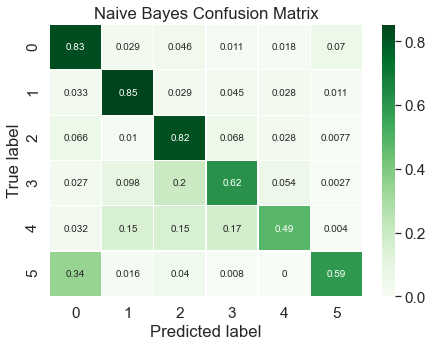

In [110]:
fig = classif_rep(y_test, y_pred_nb, 'Naive Bayes')
fig.figure.savefig(fig_save_path + 'nb_conf_matrix.png')

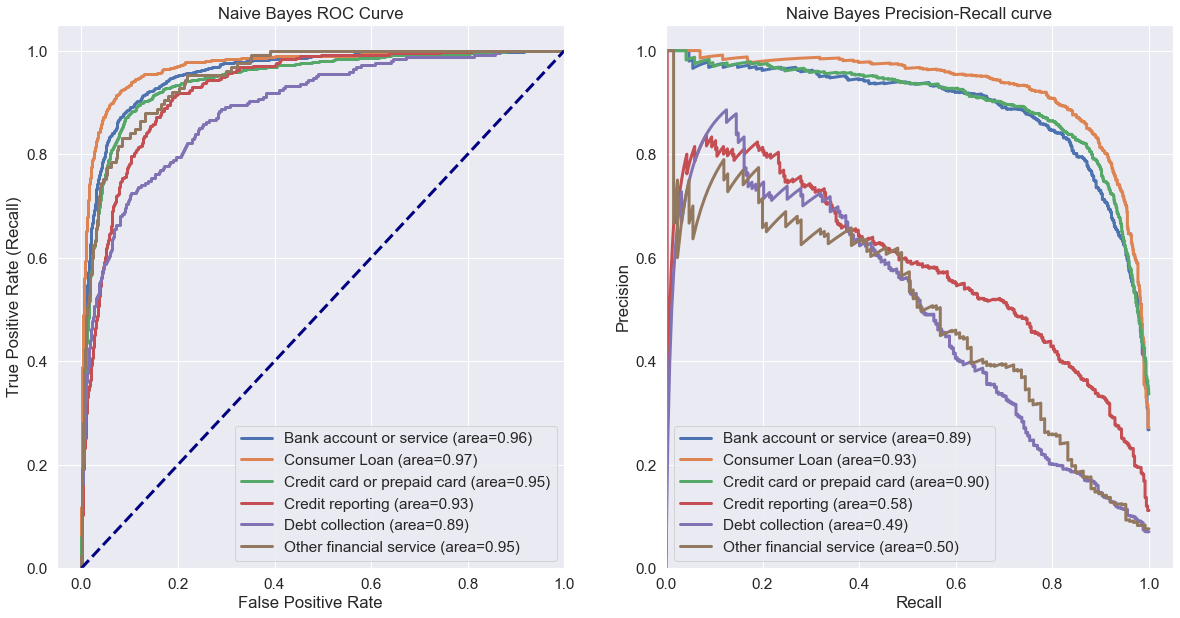

In [111]:
fig = plot_roc_PR_curves(y_test, y_pred_proba_nb, 'Naive Bayes')
fig.savefig(fig_save_path + 'nb_ROC_PR_curves.png')

# Model 3 - Logistic Regression
# ----------------------------------------------------------------------------
# ----------------------------------------------------------------------------

# Logistic Regression Modeling

In [114]:
t0 = time()
lr = LogisticRegression(penalty='l1', solver='saga', random_state=34)
lr = lr.fit(tfidf_sm, y_sm)
y_pred_lr = lr.predict(tfidf_test)
y_pred_proba_lr = lr.predict_proba(tfidf_test)
runtime_lr = round((time() - t0) / 60,1)
print('Runtime:', runtime_lr, 'minutes')

metrics_lr = ['Logistic Regression', round(f1_score(y_test, y_pred_lr, average='weighted'),3), runtime_lr]

/Users/joeboardman/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Runtime: 22.9 minutes


In [209]:
# 3-fold cross validation
cv_scores_lr = cross_val_score(lr, tfidf_sm_lr, y_sm, scoring='accuracy', cv=3, n_jobs=-1)

In [210]:
# print cv scores
print('Cross Validation Accuracy Scores: ',cv_scores_lr)

Cross Validation Accuracy Scores:  [0.84123549 0.87487704 0.89228802]


Model Results:


Weighted f1-score: 0.786


Classicication Report:
                             precision    recall  f1-score   support

    Bank account or service       0.84      0.80      0.82      1005
              Consumer Loan       0.88      0.84      0.86       961
Credit card or prepaid card       0.85      0.81      0.83      1293
           Credit reporting       0.57      0.66      0.61       369
            Debt collection       0.50      0.56      0.53       247
    Other financial service       0.46      0.69      0.55       125

                   accuracy                           0.78      4000
                  macro avg       0.68      0.73      0.70      4000
               weighted avg       0.79      0.78      0.79      4000



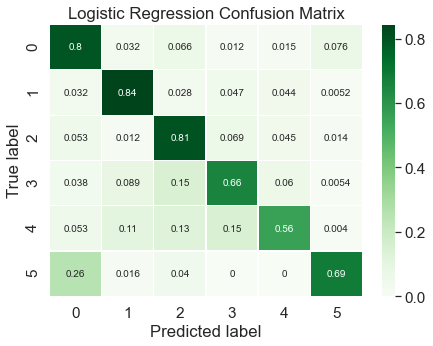

In [115]:
fig = classif_rep(y_test, y_pred_lr, 'Logistic Regression')
fig.figure.savefig(fig_save_path + 'lr_conf_matrix.png')

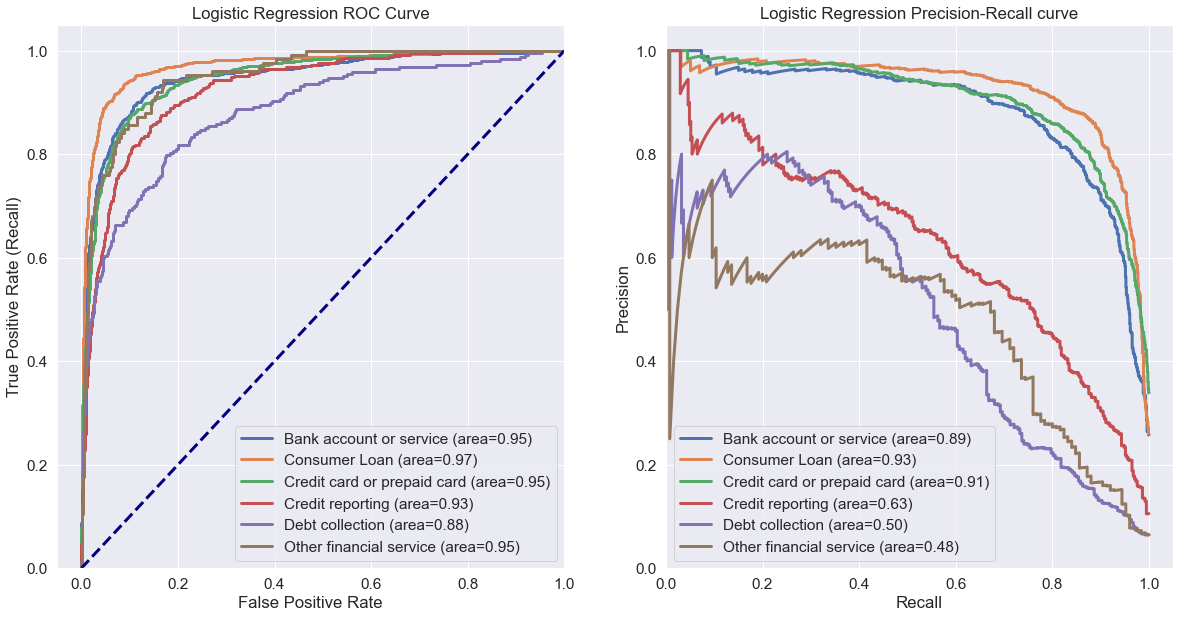

In [116]:
fig = plot_roc_PR_curves(y_test, y_pred_proba_lr, 'Logistic Regression')
fig.savefig(fig_save_path + 'lr_ROC_PR_curves.png')

# Conclusions

- Upon running and evaluating three models, I found the best option to be the Naive Bayes model due to the similar classification performance and faster runtime.

### Possible Next Steps:
- Would like to try neural network
- Pyspark to be able to run full tfidf

In [118]:
cols = ['Model', 'Weighted f1', 'Runtime (mins)']
df_metrics = pd.DataFrame(data=[metrics_rf, metrics_nb, metrics_lr], columns=cols).set_index('Model')
df_metrics

,Weighted f1,Runtime (mins)
Model,,
Random Forest Classification,0.787,1.0
Naive Bayes Classification,0.786,0.0
Logistic Regression,0.786,22.9
